# Trabalho 05 - Classificação

In [404]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.calibration import LabelEncoder
from scipy.stats import zscore
from AnalysisUtils import print_simple_metrics, boxplot_with_quartiles, create_filtered_histograms

In [405]:
def load_data():
    return pd.read_csv('data/trabalho5_dados_4.csv')


def preprocess_data(df, categorical_columns, inputting_method):
    # display(((df == 'MD') | df.isna()).sum())
    df = df.replace('MD', np.nan)
    df = fill_missing_data(df, method=inputting_method)

    df['Quantitative Ability 1'] = df['Quantitative Ability 1'].astype(float)
    df['Analytical Skills 1'] = df['Analytical Skills 1'].astype(float)
    df['Domain Skills 1'] = df['Domain Skills 1'].astype(float)

    df['Year of Birth'] = df['Year of Birth'].map(lambda x: x[1:]).astype(int)
    df['10th Completion Year'] = df['10th Completion Year'].map(
        lambda x: x[1:]).astype(int)
    df['12th Completion year'] = df['12th Completion year'].map(
        lambda x: x[1:]).astype(int)
    df[' Year of Completion of college'] = df[' Year of Completion of college'].map(
        lambda x: x[1:]).astype(int)

    df.rename(columns={
              ' Year of Completion of college': 'Year of Completion of college'}, inplace=True)
    df.rename(columns={' 10th percentage': '10th percentage'}, inplace=True)
    df.rename(columns={' 12th percentage': '12th percentage'}, inplace=True)
    df.rename(
        columns={' College percentage': 'College percentage'}, inplace=True)
    df.rename(columns={' English 1': 'English 1'}, inplace=True)

    df = encode_string_columns(df, categorical_columns)
    df = df.drop_duplicates(df, keep='first')  # Removeu 55 duplicatas

    return df


def fill_missing_data(df, method='knn', n_neighbors=5):
    if method == 'simple':
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].mean())
            else:
                if df[col].notna().any():
                    df[col] = df[col].fillna(df[col].mode()[0])

    elif method == 'knn':
        # Separate numeric and non-numeric columns
        df_numeric = df.select_dtypes(include=['float64', 'int64'])
        df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

        # Apply get_dummies for non-numeric columns to perform one-hot encoding
        df_non_numeric_dummies = pd.get_dummies(
            df_non_numeric, drop_first=False)

        # Impute using KNN
        imputer_numeric = KNNImputer(n_neighbors=n_neighbors)
        imputer_non_numeric = KNNImputer(n_neighbors=1)

        df_imputed_numeric = pd.DataFrame(
            imputer_numeric.fit_transform(df_numeric),
            columns=df_numeric.columns,
            index=df_numeric.index
        )

        df_imputed_non_numeric = pd.DataFrame(
            imputer_non_numeric.fit_transform(df_non_numeric_dummies),
            columns=df_non_numeric_dummies.columns,
            index=df_non_numeric_dummies.index
        )
        # Reverse the one-hot encoding by getting the most frequent category for each column
        df_non_numeric_imputed = pd.DataFrame(
            index=df_imputed_non_numeric.index)
        for col in df_non_numeric.columns:
            vals_col = df_non_numeric[col].dropna().unique()

            dummies = [col + '_' + str(val) for val in vals_col]
            dummies_values = df_imputed_non_numeric[dummies].idxmax(
                axis=1).apply(lambda x: x.split('_')[-1])
            df_non_numeric_imputed[col] = dummies_values

        # Combine numeric and non-numeric back to the original DataFrame
        df = pd.concat([df_imputed_numeric, df_non_numeric_imputed], axis=1)

    else:
        raise ValueError("Invalid method. Choose from 'simple' or 'knn'.")

    return df


def encode_string_columns(df, categorical_columns: list[str]):
    for col in categorical_columns:
        # Get the unique values in the column
        unique_values = df[col].dropna().unique()

        if col == 'Gender':
            df['dummy_Gender'] = df[col].str.lower().map({'A': 0, 'B': 1})
            continue

        if col == 'Month of Birth':
            df['dummy_Month of Birth'] = df[col].str.lower().map({
                'JAN': 0,
                'FEB': 1,
                'MAR': 2,
                'APR': 3,
                'MAY': 4,
                'JUN': 5,
                'JUL': 6,
                'AUG': 7,
                'SEP': 8,
                'OCT': 9,
                'NOV': 10,
                'DEC': 11,
            })
            continue

        if len(unique_values) == 2:
            label_encoder = LabelEncoder()
            df[f"dummy_{col}"] = label_encoder.fit_transform(df[col])
            continue
        else:
            df_dummies = pd.get_dummies(df[col], prefix=f"dummy_{col}")
            df = pd.concat([df, df_dummies], axis=1)
            continue

    return df


def detect_outliers_by_iiq(df, numerical_columns):
    outlier_counts = {}

    for col in numerical_columns:
        col_values = df[col].dropna()
        q1, q3 = np.percentile(col_values, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outlier_counts[col] = ((df[col] < lower_bound) |
                               (df[col] > upper_bound)).sum()

    return pd.Series(outlier_counts)


def plot_all_category_columns(df, category_columns, color='skyblue', top=10):
    num_columns = len(category_columns)
    rows = (num_columns // 3) + (num_columns % 3 > 0)

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for idx, column in enumerate(category_columns):
        ax = axes[idx]

        # Get the value counts for the encoded column
        result_df = df[column].value_counts().reset_index()
        result_df.columns = [column, 'Count']
        result_df['Percentage'] = (
            result_df['Count'] / result_df['Count'].sum()) * 100

        # Keep only top N values if specified
        result_df = result_df.head(top)

        # Plot the bar chart
        result_df.plot(kind='bar', x=column, y='Count',
                       color=color, ax=ax, legend=False)

        ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
        ax.set_xlabel('Values', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.tick_params(axis='x', rotation=45)

        for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
            ax.text(i, count + 0.5,
                    f'{count} / {pct:.1f}%', ha='center', va='bottom')

    # Remove any empty axes
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.tight_layout()
    plt.show()


def analyze_all_numerical_columns(df, numerical_columns):
    for row in numerical_columns:
        analyze_numerical_column(df[row]) 


def analyze_numerical_column(row):
  print_simple_metrics(row)
  boxplot_with_quartiles(row, yscale='linear')
  create_filtered_histograms(row, log=False, filters=None, color='blue', bins=100)

In [406]:
numerical_columns = [
    '10th percentage',
    '12th percentage',
    'College percentage',
    'English 1',
    'English 2',
    'English 3',
    'English 4',
    'Quantitative Ability 1',
    'Quantitative Ability 2',
    'Quantitative Ability 3',
    'Quantitative Ability 4',
    'Domain Skills 1',
    'Domain Skills 2',
    'Domain Test 3',
    'Domain Test 4',
    'Analytical Skills 1',
    'Analytical Skills 2',
    'Analytical Skills 3', 
    'Year of Birth',
    '10th Completion Year',
    '12th Completion year',
    'Year of Completion of college'
]

categorical_columns = [
    'Month of Birth',
    'Gender',
    'State (Location)',
    'Degree of study',
    'Specialization in study'
]

ignored_columns = [
    'Candidate ID',
    'Name',
    'Number of characters in Original Name'
]

y_column = 'Performance'

In [407]:
original_df = load_data()
df = preprocess_data(original_df, categorical_columns, inputting_method='knn')
df

,Candidate ID,Number of characters in Original Name,10th percentage,12th percentage,College percentage,English 1,English 2,English 3,English 4,Quantitative Ability 2,...,dummy_Specialization in study_C,dummy_Specialization in study_D,dummy_Specialization in study_E,dummy_Specialization in study_F,dummy_Specialization in study_G,dummy_Specialization in study_H,dummy_Specialization in study_I,dummy_Specialization in study_J,dummy_Specialization in study_K,dummy_Specialization in study_L
0,1056.0,11.0,74.20,69.60,73.20,37.735849,57.961783,60.000000,59.509202,58.083832,...,False,False,False,False,False,False,False,False,False,False
1,1058.0,12.0,80.33,72.20,76.32,54.716981,73.248408,69.696970,68.098160,54.491018,...,False,False,False,False,True,False,False,False,False,False
2,1059.0,13.0,77.80,74.40,67.90,66.037736,89.808917,60.000000,61.963190,52.095808,...,False,False,False,False,False,False,False,False,False,False
3,1062.0,16.0,77.50,72.40,72.40,41.509434,60.509554,55.151515,69.325153,77.245509,...,False,False,False,False,False,False,False,False,False,False
4,1063.0,11.0,80.53,75.83,66.31,71.698113,89.808917,78.181818,68.098160,66.467066,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,248.0,13.0,89.40,70.10,77.60,49.056604,69.426752,52.727273,69.325153,76.047904,...,False,False,False,False,False,False,False,False,False,True
462,85.0,16.0,78.60,88.58,77.00,32.075472,65.605096,58.787879,57.055215,60.479042,...,False,False,False,False,False,False,False,False,False,False
463,474.0,9.0,89.00,71.00,65.60,83.018868,65.605096,89.090909,58.282209,74.850299,...,False,False,False,False,False,False,False,False,False,False
464,318.0,13.0,84.40,79.20,78.03,60.377358,79.617834,75.757576,60.736196,68.862275,...,False,False,False,False,False,False,False,False,False,False


In [408]:
dummy_columns = [column for column in df.columns if column not in (numerical_columns + ignored_columns + [y_column] + categorical_columns)]

In [409]:
detect_outliers_by_iiq(df, numerical_columns)

10th percentage                   5
12th percentage                   0
College percentage                2
English 1                         3
English 2                        12
English 3                         7
English 4                         3
Quantitative Ability 1            2
Quantitative Ability 2            4
Quantitative Ability 3            4
Quantitative Ability 4            4
Domain Skills 1                  13
Domain Skills 2                   4
Domain Test 3                     4
Domain Test 4                     2
Analytical Skills 1               1
Analytical Skills 2               5
Analytical Skills 3               1
Year of Birth                    18
10th Completion Year             83
12th Completion year             81
Year of Completion of college     1
dtype: int64

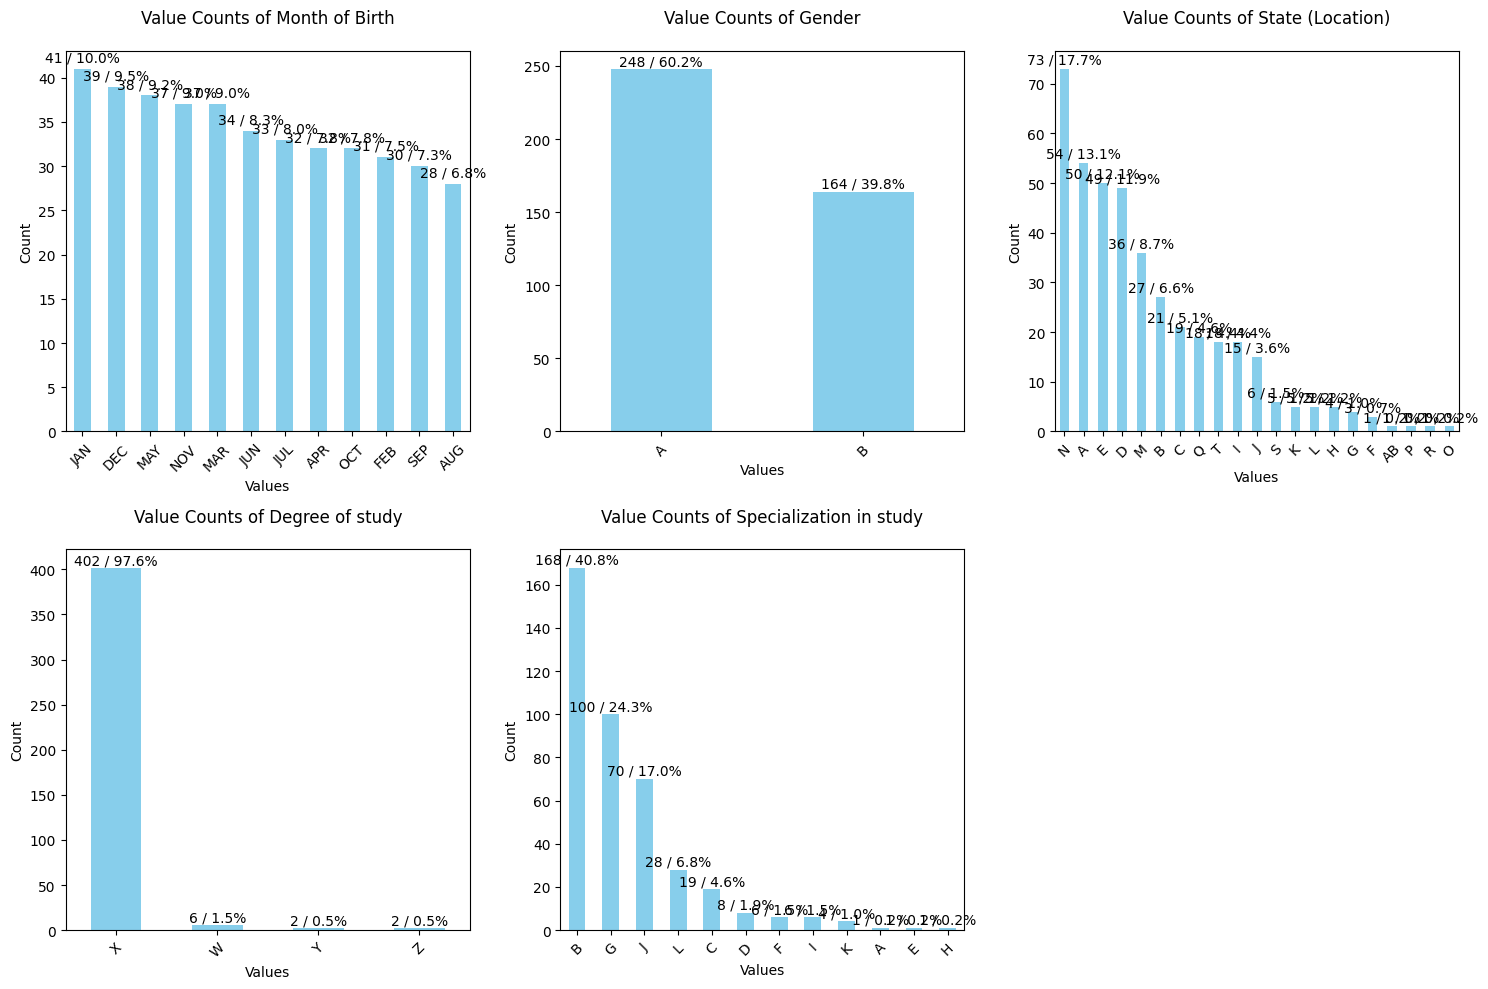

In [410]:
plot_all_category_columns(df, categorical_columns, color='skyblue', top=40)

In [411]:
# analyze_all_numerical_columns(df, numerical_columns)